# Imports & DB Connection

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Load processed final_df

In [27]:
final_df = pd.read_csv('../data/processed/reviews_final.csv')
final_df.head()

,Unnamed: 0,review_text,rating,review_date,bank_name,sentiment_score,sentiment_label,clean_text,topic,theme
0,0,The app makes our life easier. Thank you CBE!,5,2025-11-27,Commercial Bank of Ethiopia,0.000000,Neutral,app makes life thank,2,User Experience / App Features
1,1,this app very bad,1,2025-11-27,Commercial Bank of Ethiopia,-0.910000,Negative,app bad,2,User Experience / App Features
2,2,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia,0.466667,Neutral,advanced stay,2,User Experience / App Features
3,3,Good application,4,2025-11-27,Commercial Bank of Ethiopia,0.700000,Positive,good application,0,Ease of Use / Performance
4,4,It is nice app,5,2025-11-26,Commercial Bank of Ethiopia,0.600000,Positive,nice app,2,User Experience / App Features


# Identify Drivers and Pain Points

In [28]:
bank_sentiment = final_df.groupby(['bank_name'])['sentiment_score'].mean().reset_index()
bank_sentiment

,bank_name,sentiment_score
0,Bank of Abyssinia,0.073285
1,Commercial Bank of Ethiopia,0.263583
2,Dashen Bank,0.283594


# Compare Banks

In [29]:
comparsion = final_df.groupby(['bank_name', 'sentiment_label']).size().unstack(fill_value=0)
comparsion

sentiment_label,Negative,Neutral,Positive
bank_name,,,
Bank of Abyssinia,31,380,70
Commercial Bank of Ethiopia,10,331,137
Dashen Bank,13,351,132


# Compare Banks based on the final_result's themes

In [30]:
comparsion = final_df.groupby(['bank_name', ])['theme'].value_counts()
comparsion

bank_name                    theme                              
Bank of Abyssinia            User Experience / App Features         411
                             Positive Feedback / UI Appreciation     34
                             Ease of Use / Performance               28
                             Bugs / Issues / Reliability              8
Commercial Bank of Ethiopia  User Experience / App Features         403
                             Ease of Use / Performance               40
                             Positive Feedback / UI Appreciation     28
                             Bugs / Issues / Reliability              6
                             General Praise / Mixed Feedback          1
Dashen Bank                  User Experience / App Features         368
                             General Praise / Mixed Feedback         73
                             Bugs / Issues / Reliability             24
                             Ease of Use / Performance               17

# Visualization

## 1. Sentiment Distribution per Bank (Bar Plot)

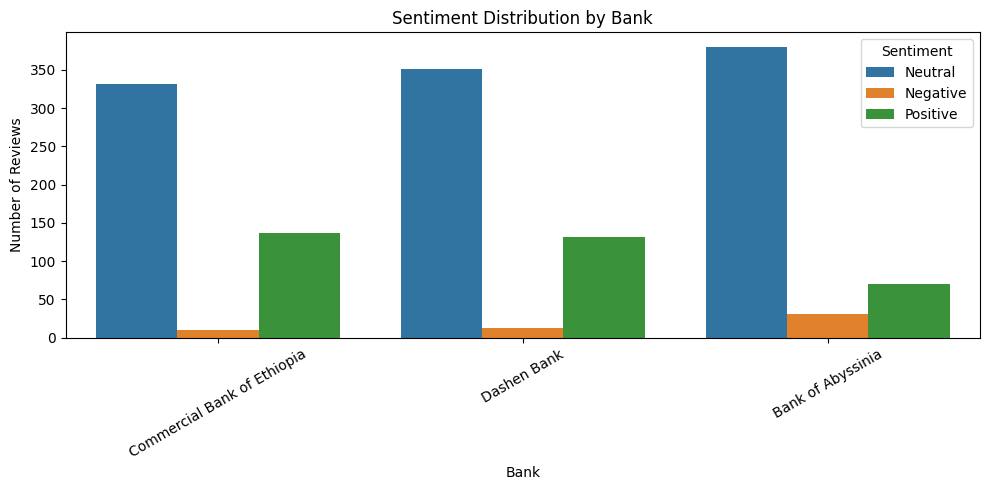

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(data=final_df, x='bank_name', hue='sentiment_label')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 2. Rating Distribution per Bank (Box Plot)

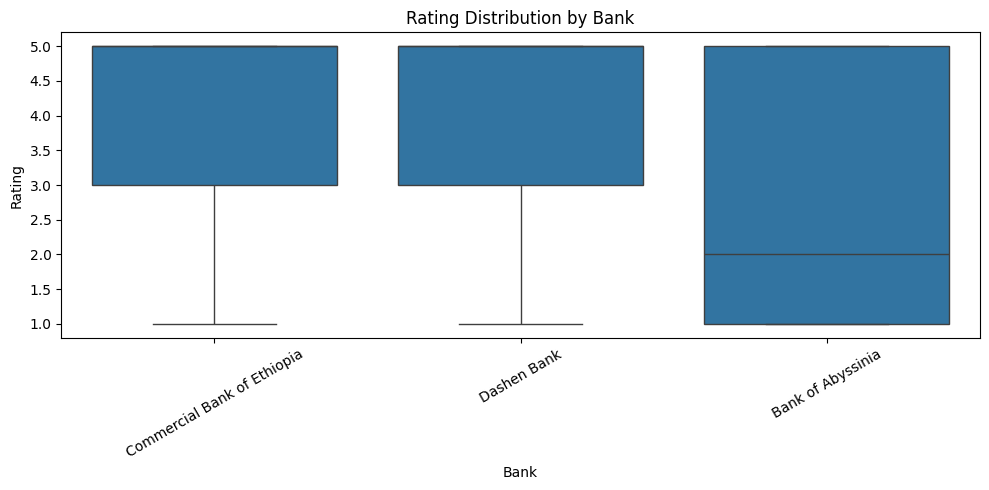

In [32]:
plt.figure(figsize=(10,5))
sns.boxplot(x=final_df['bank_name'], y=final_df['rating'])
plt.title("Rating Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Rating")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 3. Sentiment Trend Over Time (Line Chart)

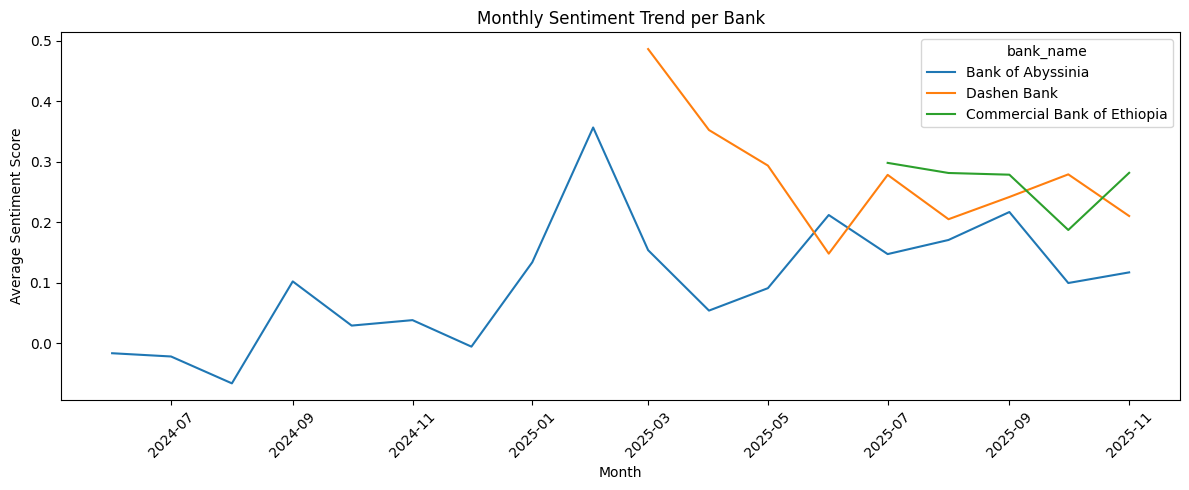

In [33]:
final_df['review_date'] = pd.to_datetime(final_df['review_date'])

trend = (
    final_df.groupby([final_df['review_date'].dt.to_period('M'), 'bank_name'])['sentiment_score']
      .mean()
      .reset_index()
)

trend['review_date'] = trend['review_date'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=trend, x='review_date', y='sentiment_score', hue='bank_name')
plt.title("Monthly Sentiment Trend per Bank")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Keyword Cloud per Bank (WordCloud)

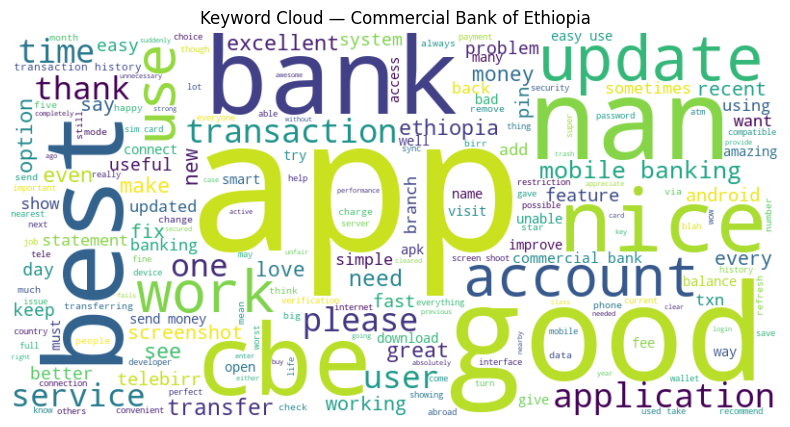

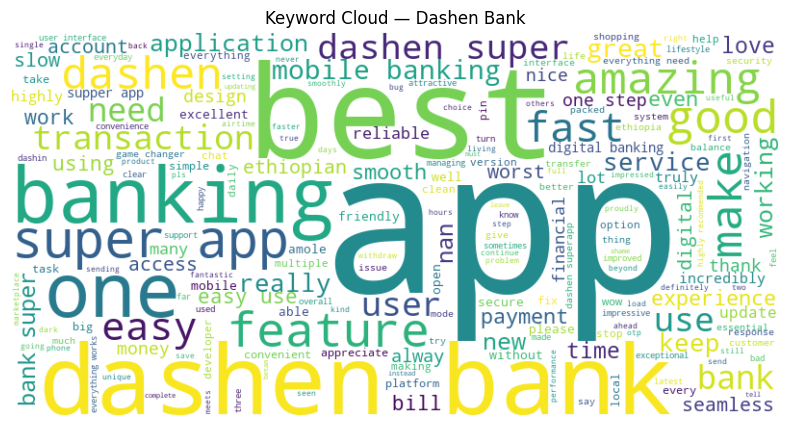

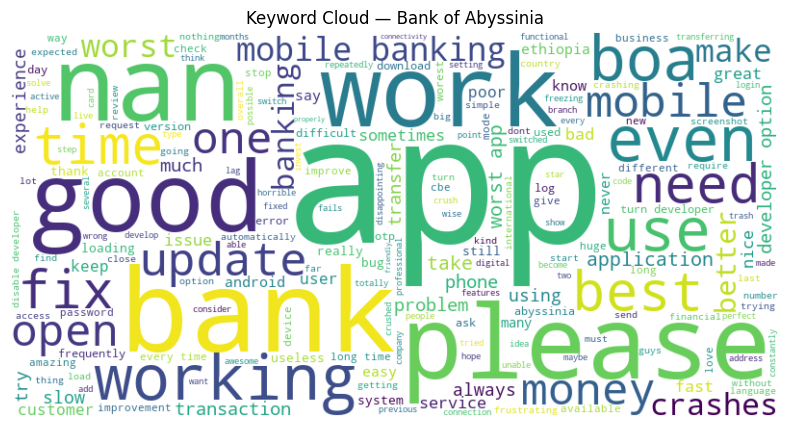

In [34]:


for bank in final_df['bank_name'].unique():
    text = " ".join(final_df[final_df['bank_name'] == bank]['clean_text'].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Keyword Cloud — {bank}")
    plt.show()
